# What is times series?

Time series is a type of data that is sampled based on time dimension like days, weeks or months. 

<h3>Different problems</h3>
There are different problems related to time series:

1. prediction or forcasting
2. Imputation (Projecting back into the past or filling holes - the missing data)
3. Detect anomalies
4. Detecting patterns: Detecting whether the time series is stationary or is following a trend. We can also analyse the seasonality of the data.

<h3>patterns</h3>

1. trends: upside or downward trends
2. seasonalities: repeated patterns
3. Combination of trends and seasonalities
4. random values. 
5. Auto correlation

In reality time series are the combination of all of these patterns: Trend + seasonality + Auto correlation + Noise

## A temperature forecasting example

Forcasting is the most common problem when it comes to time series. Here, we start with a very popular dataset called The Jena Climate dataset recorded by the Max Planck Institute for Biogeochemistry.
The dataset can be downloaded from the following link:

https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

The dataset consists of 14 features such as temperature, pressure, humidity etc, recorded once per 10 minutes.

In [79]:
import pandas as pd
df = pd.read_csv("files/jena_climate_2009_2016.csv")
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


The following picture shows the plot of temperature (in degrees Celsius) over time. The plot clearly shows the seasonality, trend and the noise in the data. The whole time series spans over 8 years.


<AxesSubplot: >

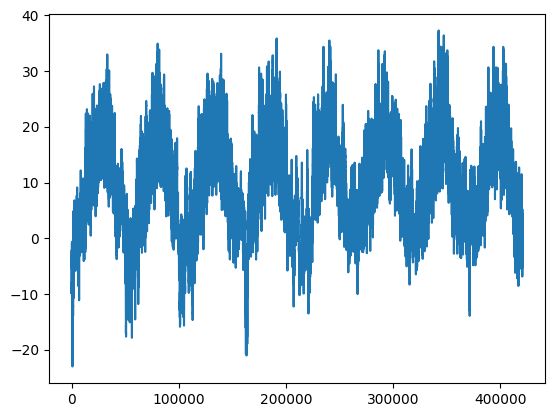

In [80]:
df["T (degC)"].plot()

* Periodicity: The temperature goes up and down every year.
* Trend: The upward trend is visible as the minimum and the maximum temperates are slightly larger every year.
* Noise: It can be clearly seen that the temperature data is noisy. Although it goes through a vivid pattern, it also fluctuates a lot between the measurments. It does not mov smoothly.


In this example, we will target a single problem: predicting the temperature 24 hours in the future, given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity, recorded over the recent past by a set of sensors on the roof of a building. 

### Baseline forcasting
First, we try to create a model that predicts the next temperature value without using machine learning. This will be our baseline when we use machine learning approach.

We start by removing the date field and converting the pandas dataframe to a nupy array:

In [81]:
import numpy as np
raw_data = np.zeros([df.values.shape[0] , df.values.shape[1]-1])
raw_data[:] = df.values[:,1:]

The following print shows that nothing has changed yet, we just dropped the date field and converted it to a numpy array:

In [82]:
df.iloc[0] , raw_data[0]

(Date Time          01.01.2009 00:10:00
 p (mbar)                        996.52
 T (degC)                         -8.02
 Tpot (K)                         265.4
 Tdew (degC)                       -8.9
 rh (%)                            93.3
 VPmax (mbar)                      3.33
 VPact (mbar)                      3.11
 VPdef (mbar)                      0.22
 sh (g/kg)                         1.94
 H2OC (mmol/mol)                   3.12
 rho (g/m**3)                   1307.75
 wv (m/s)                          1.03
 max. wv (m/s)                     1.75
 wd (deg)                         152.3
 Name: 0, dtype: object,
 array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
         9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
         1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
         1.75000e+00,  1.52300e+02]))

Then, we need to create a train, validation and text datasets. Before that, we create an array called temperature that keeps our target values:

In [83]:
temperature = df["T (degC)"].to_numpy()
temperature.shape

(420451,)

Now, we split the raw data into three arrays. We use the first 50% of the data samples to create the model. The next 25% samples for validation and the rest will be used for testing.
There is an important reason why we did not flush the data, and just used the data in order. This is because the in time series we are not allowed to use information that is gathered from the data samples in the future!

In [84]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

To create the datasets, we use the <code>timeseries_dataset_from_array</code> function from keras. This function needs the a few parameters to create a BatchDataSet. For example, consider a time series containing the numbers from 1 to 20.

In [85]:
sample_raw_data = np.array(range(1,20))
sample_raw_data

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

In [86]:
import tensorflow as tf

In [87]:
sample_train_set = tf.keras.utils.timeseries_dataset_from_array(
    data=sample_raw_data[:-1],
    targets=sample_raw_data[5:],
    sampling_rate=2,
    batch_size=5,
    sequence_length=3,
)

By running the above code, we create a batch data set. Batch dataset is a specific type of tensorflow dataset that contains multiple batches of data: We can iterate through the batches to see what is inside each batch:

In [88]:
for batch in sample_train_set:
    print()
    print("Sequences = " , batch[0])
    print("Targets = " , batch[1])


Sequences =  tf.Tensor(
[[1 3 5]
 [2 4 6]
 [3 5 7]
 [4 6 8]
 [5 7 9]], shape=(5, 3), dtype=int64)
Targets =  tf.Tensor([ 6  7  8  9 10], shape=(5,), dtype=int64)

Sequences =  tf.Tensor(
[[ 6  8 10]
 [ 7  9 11]
 [ 8 10 12]
 [ 9 11 13]
 [10 12 14]], shape=(5, 3), dtype=int64)
Targets =  tf.Tensor([11 12 13 14 15], shape=(5,), dtype=int64)

Sequences =  tf.Tensor(
[[11 13 15]
 [12 14 16]
 [13 15 17]], shape=(3, 3), dtype=int64)
Targets =  tf.Tensor([16 17 18], shape=(3,), dtype=int64)


As you can see, each batch is actually a tuple containing a tensor od samples and an array of target values. The function has created a batch dataset that contains batches of size 5, meaning that each batch has 5 samples in it. The samples are sequences with length 3. Something very nice about this function is that it even handles sampling rate for us. Sampling rate is a value that is taken into account when the sequences of numbers are generated. It can be seen that the sampling rate of 2 means that only one number of two numbers is kept during the sequence generation.

The data and target parameters are easy to understand. The point is that the target value is kept in the second value of the tuple.

There is another parameter called shuffle that is used to shuffle the sequences. Lets run the same code with shuffle = True:

In [89]:
sample_train_set = tf.keras.utils.timeseries_dataset_from_array(
    data=sample_raw_data[:-1],
    targets=sample_raw_data[5:],
    sampling_rate=2,
    batch_size=5,
    sequence_length=3,
    shuffle=True
)

for batch in sample_train_set:
    print()
    print("Sequences = " , batch[0])
    print("Targets = " , batch[1])


Sequences =  tf.Tensor(
[[ 9 11 13]
 [ 8 10 12]
 [ 4  6  8]
 [12 14 16]
 [13 15 17]], shape=(5, 3), dtype=int64)
Targets =  tf.Tensor([14 13  9 17 18], shape=(5,), dtype=int64)

Sequences =  tf.Tensor(
[[ 5  7  9]
 [10 12 14]
 [ 1  3  5]
 [ 3  5  7]
 [ 6  8 10]], shape=(5, 3), dtype=int64)
Targets =  tf.Tensor([10 15  6  8 11], shape=(5,), dtype=int64)

Sequences =  tf.Tensor(
[[ 2  4  6]
 [11 13 15]
 [ 7  9 11]], shape=(3, 3), dtype=int64)
Targets =  tf.Tensor([ 7 16 12], shape=(3,), dtype=int64)


The new one is very similar to the last one. However, in the last one the sequences are randomly distributed to different batches. 

Lets run the same function and create a batch dataset for the Jena climate dataset:

In [101]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

*   <code>sampling_rate = 6</code>: means that we only keep one data point out of 6. It gives us one data point every hour because measurement is done every 10 minuts. 
*   <code>squence_length = 120</code>: This means that we use sequences of 120 data points in a row to build a model. Not clear enough? In other words, we can consider the 120 recent measurements to pedict the next value.
*   <code>delay = sampling_rate*(sequence_length+24-1)</code>: The target for a sequence will be the temperature 24 hours after the end of the sequence.

In [145]:
from tensorflow import keras

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

The first heuristic that helps us create a prediction model is that the temperature of the tommorrow is usually close the the current value. It very rarely changes drastically during a day. Therefore the first thing that comes to mind is that we predict the temperature according to the current value.

In [92]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

samples[:, -1, 1] means all sequences, the last value and the second column which is the temperature. In other words, we use the last temperature in the sequence of the measurements as for the next prediction. Then we calculate the total absolute error for test and the validation sets

In [93]:
evaluate_naive_method(test_dataset)

2.621898451761204

In [94]:
evaluate_naive_method(val_dataset)

2.441735748565516

#### Moving Average

I guess by reducing noise and smoothing the predictions we might acheive better performance. Therefore I use moving average to predict better values.

In [95]:
def evaluate_ma_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        last_measurments = samples[:, -2:, 1]
        preds = np.mean(last_measurments, axis=1)
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

In [96]:
evaluate_ma_method(val_dataset)

2.467302117958099

However, the result of the test does not look promising. The total absolute error grows despite my initial supposition. Lets try another popular technique!

#### Differencing



In [24]:
period = 51000

In [25]:
diff = np.array([temperature[period:] - temperature[:-period], temperature[:-period] , temperature[period:]]).T
diff.shape

(369451, 3)

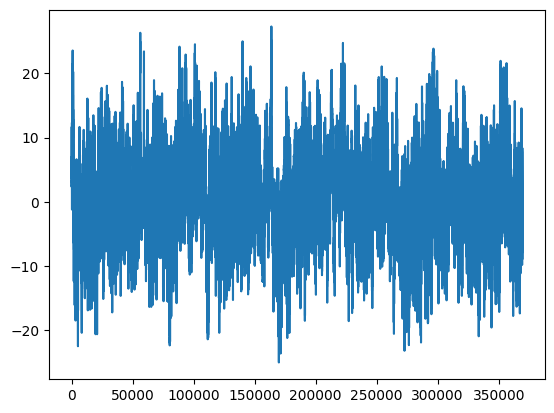

In [26]:
import matplotlib.pyplot as plt
plt.plot(diff[:,0])

In [31]:
val_diff_dataset = keras.utils.timeseries_dataset_from_array(
    data=diff[:-delay],
    targets=diff[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

In [32]:
def evaluate_diff_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        last_measurments = samples[:,-2:,0]
        preds = np.mean(last_measurments, axis=1)
        preds = preds + samples[:,-1,1]
        total_abs_err += np.sum(np.abs(preds - targets[:,2]))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

In [33]:
evaluate_diff_method(val_diff_dataset)

2.6682176965888496

Neither moving average nor differencing method can better the performance of the baseline. Therefore, we set 2.44 as our target mae. 

### Using statis neural network

Now the game is to use your knowledge of deep learning to do better. better than 2.44 on the validation set. You need to beat the baeline.

First I try to use the same heuristic for training a neural network. This means that I have to create a dataset that includes only temperatures:

In [107]:
t_train_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
t_val_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
t_test_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [ ]:
model1 = keras.Sequential([
    keras.layers.Input(shape=(sequence_length, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])
model1.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history1 = model1.fit(t_train_dataset, validation_data=t_val_dataset, epochs=10)

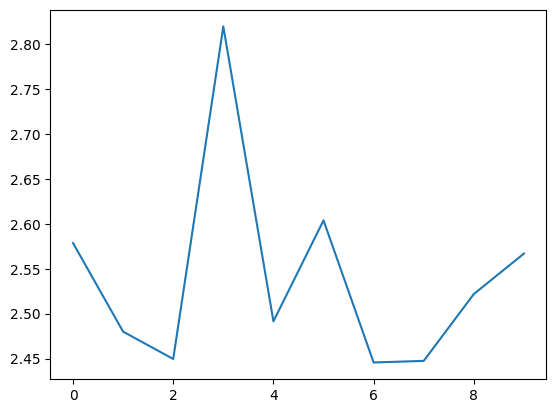

In [173]:
plt.plot(history1.history["val_mae"])

In [174]:
history1.history["val_mae"][6]

2.4456450939178467

Altough the neural network performs better than the moving average and differencing, it cannot beat the naive method! 

Now, lets create the same model using the functional API just out of curiosity!

In [201]:
inputs = keras.Input(shape=(sequence_length, 1), name="inputs")
flatten = keras.layers.Flatten()(inputs)
outputs = keras.layers.Dense(1, name="outputs")(flatten)
model2 = keras.Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer="rmsprop", loss={"outputs":"mse"}, metrics=["mae"])
history2 = model2.fit(t_train_dataset, validation_data=t_val_dataset, epochs=20)

Epoch 1/20
819/819 [==============================] - 16s 19ms/step - loss: 16.4489 - mae: 3.1452 - val_loss: 10.4920 - val_mae: 2.5307
Epoch 2/20
819/819 [==============================] - 16s 19ms/step - loss: 12.4525 - mae: 2.7832 - val_loss: 10.3578 - val_mae: 2.5060
Epoch 3/20
819/819 [==============================] - 16s 19ms/step - loss: 12.0554 - mae: 2.7374 - val_loss: 10.4335 - val_mae: 2.5137
Epoch 4/20
819/819 [==============================] - 16s 19ms/step - loss: 11.8876 - mae: 2.7202 - val_loss: 9.6592 - val_mae: 2.4287
Epoch 5/20
819/819 [==============================] - 16s 19ms/step - loss: 11.7921 - mae: 2.7084 - val_loss: 11.0884 - val_mae: 2.6302
Epoch 6/20
819/819 [==============================] - 16s 19ms/step - loss: 11.7133 - mae: 2.7002 - val_loss: 10.8118 - val_mae: 2.5955
Epoch 7/20
819/819 [==============================] - 15s 19ms/step - loss: 11.6639 - mae: 2.6929 - val_loss: 9.7428 - val_mae: 2.4299
Epoch 8/20
819/819 [==============================

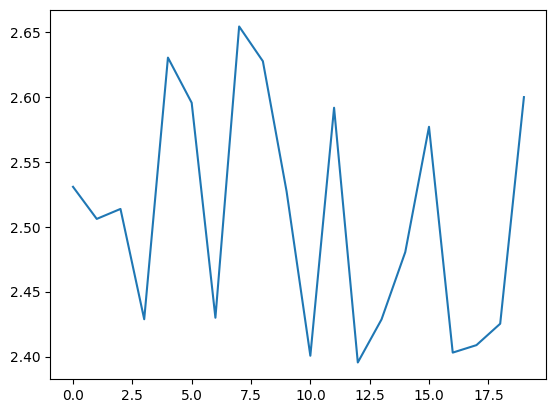

In [202]:
plt.plot(history2.history["val_mae"])

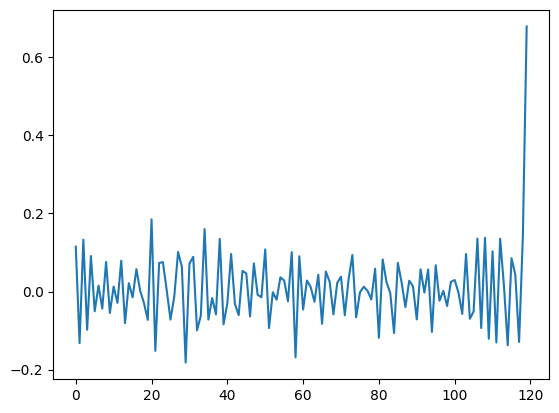

In [204]:
w= model2.get_layer("outputs").get_weights()
plt.plot(w[0])

In [205]:
inputs = keras.Input(shape=(sequence_length, 1), name="inputs")
flatten = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(16, name="x")(flatten)
outputs = keras.layers.Dense(1, name="outputs")(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer="rmsprop", loss={"outputs":"mse"}, metrics=["mae"])
history2 = model2.fit(t_train_dataset, validation_data=t_val_dataset, epochs=20)

Epoch 1/20
819/819 [==============================] - 16s 19ms/step - loss: 19.4981 - mae: 3.4655 - val_loss: 10.5786 - val_mae: 2.5328
Epoch 2/20
819/819 [==============================] - 15s 19ms/step - loss: 14.4422 - mae: 2.9983 - val_loss: 13.4361 - val_mae: 2.9102
Epoch 3/20
819/819 [==============================] - 16s 19ms/step - loss: 13.1579 - mae: 2.8658 - val_loss: 10.2161 - val_mae: 2.4906
Epoch 4/20
819/819 [==============================] - 16s 19ms/step - loss: 12.4619 - mae: 2.7889 - val_loss: 14.6798 - val_mae: 3.0136
Epoch 5/20
819/819 [==============================] - 16s 19ms/step - loss: 12.0948 - mae: 2.7473 - val_loss: 10.4888 - val_mae: 2.5479
Epoch 6/20
819/819 [==============================] - 15s 19ms/step - loss: 11.8243 - mae: 2.7147 - val_loss: 9.5908 - val_mae: 2.4200
Epoch 7/20
819/819 [==============================] - 15s 19ms/step - loss: 11.6322 - mae: 2.6927 - val_loss: 10.4052 - val_mae: 2.5405
Epoch 8/20
819/819 [=============================

In the next example. I also use the other 13 features. I hope, these features can help us predict the temperature more accurately.

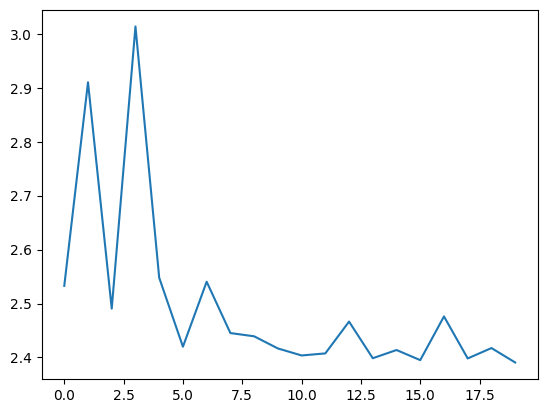

In [206]:
plt.plot(history2.history["val_mae"])

In [209]:
model2.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 120, 1)]          0         
                                                                 
 flatten_15 (Flatten)        (None, 120)               0         
                                                                 
 x (Dense)                   (None, 16)                1936      
                                                                 
 outputs (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,953
Trainable params: 1,953
Non-trainable params: 0
_________________________________________________________________


In [146]:
model = keras.Sequential([
    keras.layers.Input(shape=(sequence_length, raw_data.shape[-1])),
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1)
])
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, validation_data=val_dataset, epochs=1)

819/819 [==============================] - 16s 19ms/step - loss: 1347.6230 - mae: 12.9673 - val_loss: 150.0854 - val_mae: 10.1646


In [ ]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1,1)
axis.plot(np.arange(10), history.history["val_mae"] , "b")
axis.plot(np.arange(10), history.history["mae"] , "bo")

In the following code, we create the same model using the functional API:

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]), name="features")
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(16, activation="relu")(x)
outputs = keras.layers.Dense(1, name="temperature")(x)
model = keras.Model(inputs=inputs , outputs=outputs)
model.compile(optimizer="rmsprop" , loss={"temperature":"mse"}, metrics=["mae"])
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

In [ ]:
fig, axis = plt.subplots(1,1)
axis.plot(np.arange(10), history.history["val_mae"] , "b")
axis.plot(np.arange(10), history.history["mae"] , "bo")

In [ ]:
model = keras.Sequential([
    keras.layers.Input(shape=(sequence_length, raw_data.shape[-1])),
    keras.layers.LSTM(16),
    keras.layers.Dense(1)
])
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

In [ ]:
fig, axis = plt.subplots(1,1)
axis.plot(np.arange(1,10), history.history["val_mae"][1:] , "b")
axis.plot(np.arange(1,10), history.history["mae"][1:] , "bo")

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]), name="features")
x = keras.layers.LSTM(16)(inputs)
outputs = keras.layers.Dense(1, name="temperature")(x)
model = keras.Model(inputs=inputs , outputs=outputs)
model.compile(optimizer="rmsprop" , loss={"temperature":"mse"}, metrics=["mae"])
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)